# Corso di Probabilità e Statistica- Test statistici

In questo capitolo, faremo alcuni esempi di test statistici.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats 
import seaborn as sns
import matplotlib.pylab as plt

### Esempio: fratture 
Consideriamo di nuovo l'esempio della frattura della ceramica studiata nel capitolo 12

In [4]:
#carichiamo il file
strength = pd.read_csv("../data/Strength_ceramic.dat",
                       sep="\s+",skiprows=48)
strength=strength.drop([0])

Ricordiamo le molte variabili presenti nel file. 
Vogliamo vedere quali di questi fattori hanno un impatto significativo sul carico di rottura Y

In [7]:
with open("../data/Strength_ceramic.dat") as myfile:
    head = [next(myfile) for x in range(24)]
head


['This is Dataplot data file     JAHANMI2.DAT\n',
 'Effect of Machining Factors on Strength of Ceramics\n',
 '(Longitudinal Data Only)\n',
 'Response variable                  = ceramic strength\n',
 'Number of observations             =  480\n',
 'Number of variables per line image =   15\n',
 'Order of variables on a line image--\n',
 '   1. Factor  1 = Observation Id (1 to 960)\n',
 '   2. Factor  2 = Lab (8 levels: 1 to 8)\n',
 '   3. Factor  3 = Bar id within lab (1 to 30)\n',
 '   4. Factor  4 = Set xxx (4 levels: 1 to 4)\n',
 '   5. Response Variable Y = Strength of Ceramic\n',
 '   6. Factor  5 = Table Speed    (2 levels: slow and fast)\n',
 '   7. Factor  6 = Down Feed Rate (2 levels: slow & fast)\n',
 '   8. Factor  7 = Wheel Grit     (2 levels:     )\n',
 '   9. Factor  8 = Direction      (1 level : longitudinal only)\n',
 '  10. Factor  9 = Treatment      (2**4 = 16 levels: 1 to 16)\n',
 '  11. Factor 10 = Set of 15 within lab (2 levels: 1 and 2)\n',
 '  12. Factor 11 = Rep

Controlliamo ad esempio il fattore X1 (Table speed).
Per questo separiamo il database in due set e confrontiamoli                     

In [11]:
set1=strength[strength["X1"]==1.0].Y
set2=strength[strength["X1"]==-1.0].Y

Calcoliamo medie e varianze

In [12]:
set1.mean(),set2.mean()

(642.6228083333333, 657.5318083333334)

In [17]:
set1.std(),set2.std()

(72.8397163731925, 75.8143783939444)

Usiamo il t-test per testare l'ipotesi: I due set hanno la stessa media?

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Dato un livello di significatività, che scegliamo ad esempio $\alpha=0.01$, se il test fornisce $p<\alpha$ possiamo rigettare l'ipotesi nulla che i due set abbiano la stessa media.

In [18]:
scipy.stats.ttest_ind(set1,set2)

Ttest_indResult(statistic=-2.196874880001813, pvalue=0.02850866118896449)

Interpretazione: $p > \alpha$ e quindi non possiamo rigettare l'ipotesi che i due set abbiano la stessa media. Il che non vuol dire che abbiamo dimostrato che la media sia la stessa...

Il T-test assume che le distribuzioni siano Gaussiane e con la stessa varianza. Controlliamo quindi gli istogrammi

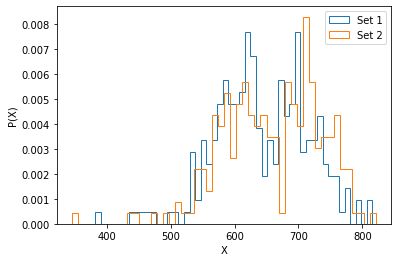

In [29]:
plt.hist(set1, bins=50, density=True, 
         histtype="step", label="Set 1" )
plt.hist(set2, bins=50, density=True, 
         histtype="step", label="Set 2")
plt.xlabel("X")
plt.ylabel("P(X)")
plt.legend()

Visto che la distribuzione non è Gaussiana utilizziamo invece  il test di Kolmogorov Smirnov.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

Per prima cosa guardiamo le distribuzioni cumulate.

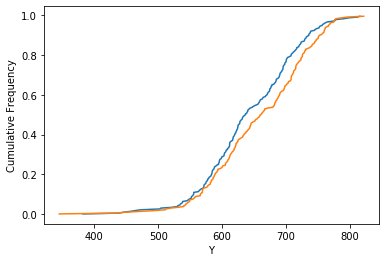

In [32]:
xmin=np.min(strength.Y)
xmax=np.max(strength.Y)
x = np.linspace(xmin,xmax,101)
y1=np.sort(set1)
idx1 = [ i/len(y1) for i in range(len(y1))]
y2=np.sort(set2)
idx2 = [ i/len(y2) for i in range(len(y2))]
plt.xlabel('Y')
plt.ylabel('Cumulative Frequency')
plt.plot(y1,idx1,label="Set 1")
plt.plot(y2,idx2,label="Set 2")


In [34]:
D,p_value=scipy.stats.ks_2samp(set1,set2)
D,p_value

(0.13333333333333333, 0.027951112440957247)

Il test KS conferma il risultato del T-test. Il fattore X1 non ha un effetto significativo sul risultato.

**Esercizio** Eseguire il test di KS per tutti i possibili fattori e identificare i fattori significativi.

### Goodness of fit

Controlliamo se il fit con MLE è "buono" con il test di KS



In [63]:
# Fittiamo con Weibull
k1, loc, x_1=scipy.stats.weibull_min.fit(set1, floc=0)
W1=scipy.stats.weibull_min(k1,loc=0, scale=x_1) 

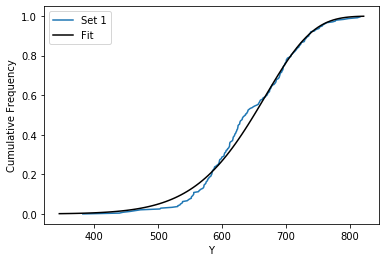

In [66]:
# Facciamo un grafico di confronto
xmin=np.min(strength.Y)
xmax=np.max(strength.Y)
x = np.linspace(xmin,xmax,101)
y1=np.sort(set1)
idx1 = [ i/len(y1) for i in range(len(y1))]
plt.xlabel('Y')
plt.ylabel('Cumulative Frequency')
plt.plot(y1,idx1,label="Set 1")
plt.plot(x, W1.cdf(x), label="Fit", color="black")
plt.legend()

Controlliamo ora il test:

In [67]:
yy=set1.to_numpy()
scipy.stats.kstest(yy, 
                  lambda x: 
                   scipy.stats.weibull_min.cdf
                   (x, k1, loc=0, scale=x_1))

KstestResult(statistic=0.0823500092370742, pvalue=0.07288497491118176)

Il test ci da un valore $p>\alpha=0.01$ quindi non possiamo rifiutare l'ipotesi che i dati siano distribuiti secondo Weibull. 

Possiamo provare ora a ripetere l'esercizio supponendo invece che i dati siano Gaussiani

In [69]:
mu_0=yy.mean()
sigma_0=yy.std()
mu_0,sigma_0

(642.6228083333333, 72.68780856160312)

In [75]:
scipy.stats.kstest(yy, 
                  lambda x: 
                   scipy.stats.norm.cdf
                   (x, loc=mu_0, scale=sigma_0))

KstestResult(statistic=0.05026754500928454, pvalue=0.5753320861840807)

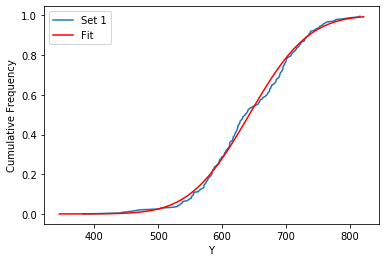

In [77]:
# Facciamo un grafico di confronto
xmin=np.min(strength.Y)
xmax=np.max(strength.Y)
x = np.linspace(xmin,xmax,101)
y1=np.sort(set1)
idx1 = [ i/len(y1) for i in range(len(y1))]
plt.xlabel('Y')
plt.ylabel('Cumulative Frequency')
plt.plot(y1,idx1,label="Set 1")
plt.plot(x, scipy.stats.norm.cdf
                   (x, loc=mu_0, scale=sigma_0), 
         label="Fit", color="red")
plt.legend()